In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data.csv',encoding = 'latin1')

In [3]:
groups = data[['app_id', 'description', 'star_rating']].groupby(['app_id','description'])

In [4]:
temp = groups.count()
temp = temp[temp['star_rating']>10]
temp = temp.rename(columns = {'star_rating': 'count'})

In [5]:
df_mean = groups.mean()
df_mean = df_mean.rename(columns = {'star_rating': 'mean_star'})
data = df_mean.merge(temp, left_index = True, right_index = True)['mean_star'].to_frame()
df_description = pd.DataFrame(data.index.values.tolist(), columns = ['app_id', 'description'])

In [6]:
df_description['mean_star'] = data['mean_star'].values

In [8]:
text = df_description['description']

ls = text.values.tolist()
import string
exclude = set(string.punctuation)
for i in range(len(ls)):
    ls[i] = ''.join(ch for ch in ls[i] if ch not in exclude)

In [9]:
len(ls)

2917

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 10,max_df=0.8)
dtm = vectorizer.fit_transform(ls)
terms = vectorizer.get_feature_names()

In [34]:
df_feature = pd.DataFrame(dtm.todense(),columns = vectorizer.get_feature_names())

In [35]:
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
np.sum(centered_dtm,axis=0)[:,:10]

matrix([[  3.92828131e-14,   2.48117499e-14,   2.52905336e-14,
           7.57705530e-15,   3.08377456e-14,  -1.11412615e-13,
          -1.00672509e-14,  -1.32424453e-14,  -4.67247768e-15,
           1.04676467e-14]])

In [36]:
u,s,vt = np.linalg.svd(centered_dtm)

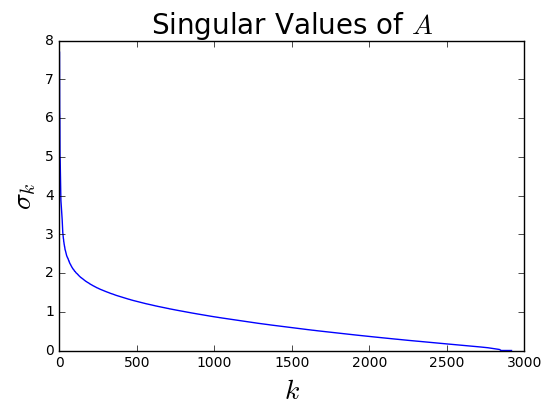

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(s)+1),s)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
_ = plt.title(r'Singular Values of $A$',size=20)

In [38]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
lsa = TruncatedSVD(100, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [39]:
Vt = pd.DataFrame(lsa.components_,columns = vectorizer.get_feature_names())
df_feature = pd.DataFrame(dtm_lsa)
labels = []
for i in range(100):
    labels.append(Vt.loc[i].nlargest(10))

In [40]:
def get_cluster(cluster, df): 
    d = {}
    i = 0
    cluster = cluster.tolist()
    while i < len(cluster):
        d.setdefault(cluster[i],[]).append(pd.DataFrame([df_feature.loc[i,]]).index.values[0])
        i = i+1
    return d

In [41]:
from sklearn.cluster import KMeans  
import sklearn.metrics as metrics
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    plt.show()

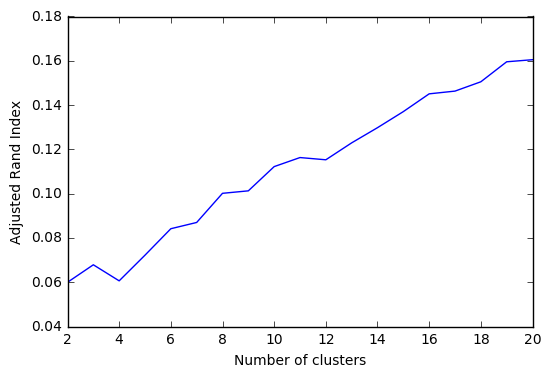

In [42]:
sc_evaluate_clusters(df_feature, 20)

In [43]:
k=14
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans_cluster = kmeans.fit_predict(df_feature)
kmeans_predict = kmeans.predict(df_feature)
kmeans_cluster

array([ 2,  3,  1, ...,  0,  2, 10])

In [44]:
kcluster = get_cluster(kmeans_cluster, df_feature)


In [ ]:
df_description.ix[kcluster[0]]['description'].values

In [51]:
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
# for i in range(k):
#     print("Cluster {}:".format(i))
#     for ind in order_centroids[i, :10]:
#         print(' {}'.format(terms[ind]))
#     print('')
# kcenter = []
# for i in range(k):
#     kcenter.append(get_center(kcluster[i])[:100])
#     kcenter[i] = np.array(kcenter[i]).argsort()[::-1]
for i in range(k):
    print("Cluster {}:".format(i))
    for j in order_centroids[i][0:5]:
        print (' {}'.format(labels[j].index.tolist()))

Top terms per cluster:
Cluster 0:
 ['game', 'mode', 'items', 'hidden', 'games', 'play', 'word', 'new', 'modes', 'puzzles']
 ['items', 'tiles', 'great', 'mahjong', 'difficulty', 'correct', 'slight', 'easiest', 'word', 'surprise']
 ['swap', 'pieces', 'correct', 'puzzle', 'spot', 'flip', 'puzzles', 'flipped', 'swapped', 'counting']
 ['flippix', 'logic', 'tiles', 'puzzles', 'hidden', 'art', 'puzzle', 'form', 'word', 'paint']
 ['tiles', 'mahjong', 'match', 'tile', 'board', 'candy', 'remove', 'layouts', 'level', 'matching']
Cluster 1:
 ['jigsaw', 'pieces', 'piece', 'puzzles', 'puzzleboss', 'puzzle', '12', 'progress', '425', 'individual']
 ['game', 'mode', 'items', 'hidden', 'games', 'play', 'word', 'new', 'modes', 'puzzles']
 ['cubes', 'smaller', 'cube', 'comprised', 'delete', 'currently', 'entertain', 'pairs', 'hidden', 'matching']
 ['swap', 'pieces', 'correct', 'puzzle', 'spot', 'flip', 'puzzles', 'flipped', 'swapped', 'counting']
 ['cubes', 'smaller', 'flippix', 'logic', 'tiles', 'cube', 

In [47]:
from sklearn import mixture
def sc_evaluate_gmm(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = mixture.GMM(n_components=k, covariance_type='full')
        gmm.fit_predict(X)
        label = gmm.predict(X)
        s[k] = metrics.silhouette_score(X,label,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    plt.show()

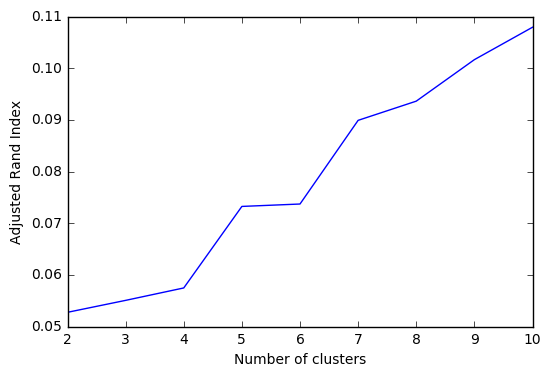

In [48]:
sc_evaluate_gmm(df_feature, 10)

In [49]:
g=8
gmm = mixture.GMM(n_components=g, covariance_type='full')
gmm.fit(df_feature)
gmm_clustering = gmm.predict(df_feature)
gmm_clustering

array([2, 0, 0, ..., 1, 2, 7], dtype=int64)

In [50]:
gcluster = get_cluster(gmm_clustering, df_feature)
glocation = {}
for i in range(g):
    glocation[i] = []
    for j in range(len(gcluster[i])):
        glocation[i].append((gcluster[i][j][-1],gcluster[i][j][-2]))

IndexError: invalid index to scalar variable.

In [ ]:
#label the gmm clusters by hot terms
gcluster = get_cluster(gmm_clustering, df_feature)
gcenter = []
for i in range(g):
    gcenter.append(get_center(gcluster[i])[:100])
    gcenter[i] = np.array(gcenter[i]).argsort()[::-1]
for i in range(g):
    print("Cluster {}:".format(i))
    for j in gcenter[i][0:5]:
        print (' {}'.format(labels[j].index.tolist()))